In [5]:
import numpy as np
import scipy.stats as stats             # For distribution functions
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d # For 3D graphs

plt.rcParams['axes.axisbelow'] = True   # Set axes and grid elements to be below the figure
# %matplotlib widget

## Variance Gamma

![Variance Gamma Process](vg_process.png)

In [6]:
N_SIMS = 20000                           # FIXME: number of simulations
N_STEPS = 200                            # FIXME: number of steps (excluding t = 0)
T = 1                                    # FIXME: time horizon
X0 = 100                                 # FIXME: initial stock price

# ABM parameters
THETA = 0.05                             # FIXME: drift of ABM
SIGMA = 0.2                              # FIXME: diffusion of ABM

# VG parameters
KAPPA = 0.1                              # FIXME: kappa of VG scale parameter of the gamma process = 1/beta = 1/rate, make kappa smaller to avoid dramatic effect (see matlab example that looks like squares)

dt = T / N_STEPS                         # Time step
t_steps = np.linspace(0, T, N_STEPS + 1)       # Time grid

# Simulation ================================================================
# Simulate Gamma Process
dG = np.random.gamma(dt / KAPPA, KAPPA, size = (N_STEPS, N_SIMS))

# Compute ABM increaments based on Gamma random clock
X = THETA * dG + SIGMA * np.sqrt(dG) * np.random.normal(size = (N_STEPS, N_SIMS))

# Accumulate ABM increments
X = np.vstack((np.zeros(N_SIMS), X.cumsum(axis = 0)))
X += X0

# Statistics ================================================================
exact_mean = THETA * t_steps + X0
exact_var = (SIGMA**2 + THETA**2 * KAPPA) * t_steps
exact_skew = (3 * SIGMA**2 + 2 * THETA**2 * KAPPA) * THETA * KAPPA / (np.power(SIGMA**2 + THETA**2 * KAPPA, 3 / 2) * np.sqrt(t_steps))
exact_kurt = (3 * SIGMA**4 + 12 * SIGMA*2 * THETA**2 * KAPPA + 6 * THETA**4 * KAPPA**2) * KAPPA / ((SIGMA**2 + THETA**2 * KAPPA)**2 * t_steps)

/var/folders/p6/smj7c6c1417csf_h79x5rk4h0000gn/T/ipykernel_22341/3618243493.py:30: RuntimeWarning: divide by zero encountered in divide
  exact_skew = (3 * SIGMA**2 + 2 * THETA**2 * KAPPA) * THETA * KAPPA / (np.power(SIGMA**2 + THETA**2 * KAPPA, 3 / 2) * np.sqrt(t_steps))
/var/folders/p6/smj7c6c1417csf_h79x5rk4h0000gn/T/ipykernel_22341/3618243493.py:31: RuntimeWarning: divide by zero encountered in divide
  exact_kurt = (3 * SIGMA**4 + 12 * SIGMA*2 * THETA**2 * KAPPA + 6 * THETA**4 * KAPPA**2) * KAPPA / ((SIGMA**2 + THETA**2 * KAPPA)**2 * t_steps)


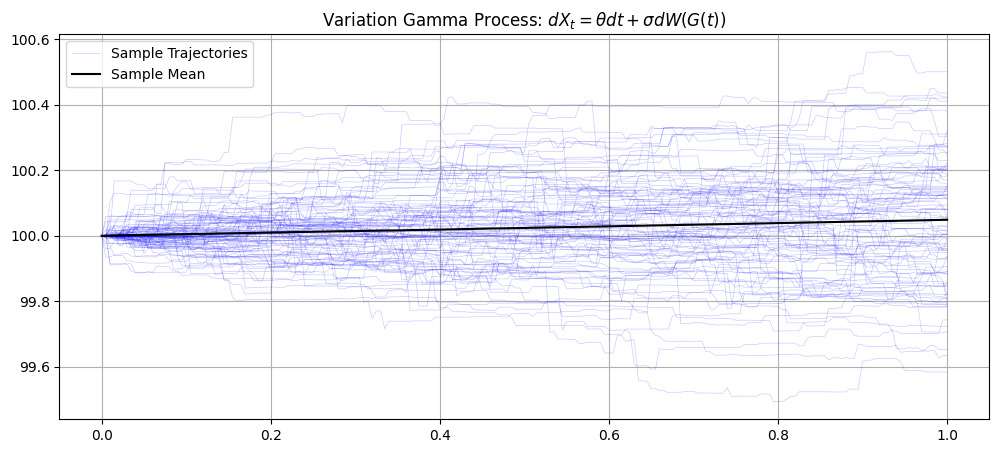

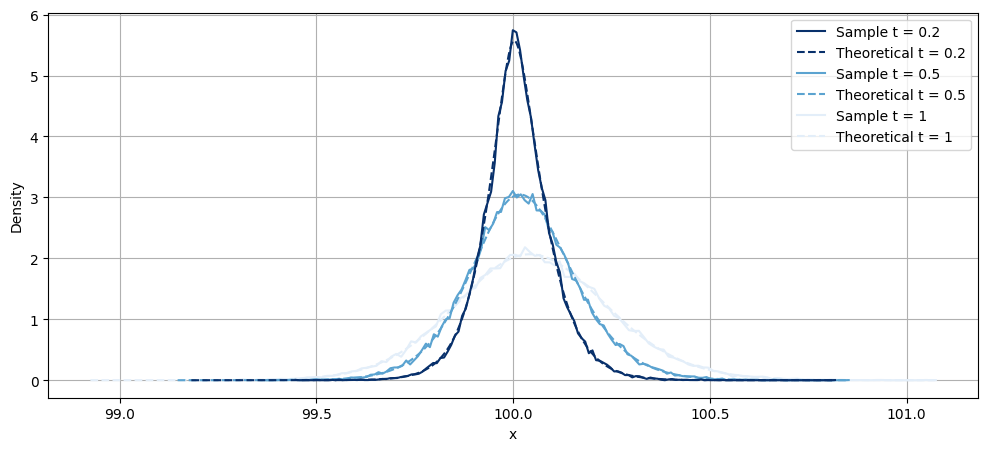

In [7]:
# Trajectories & Slices
# Price Trajectoris ==========================================================================
plt.figure(figsize = (12, 5), clear = True)

plt.title(r"Variation Gamma Process: $dX_t = \theta dt + \sigma dW(G(t))$")
plt.plot(t_steps, X[:,:100], color = "blue", alpha = 0.2, lw = 0.5, label = "Sample Trajectories")
plt.plot(t_steps, X.mean(axis = 1), color = "black", label = "Sample Mean")

handles, labels = plt.gca().get_legend_handles_labels() # This gets the handles and labels of the current axes
by_label = dict(zip(labels, handles)) # dict(zip(keys, values)) is a way to create a dictionary from two lists
plt.legend(by_label.values(), by_label.keys())
plt.grid()
plt.show()

# Slices =====================================================================================
SLICES = [0.2, 0.5, 1]       # FIXME: times to plot

plt.figure(figsize = (12, 5), clear = True)

def vg_charfunc(xi, t, theta, k, sigma):
    return (1 - 1j * xi * theta * k + 0.5 * xi**2 * sigma**2 * k)**(-t / k)

colors = plt.cm.Blues(np.linspace(0.1, 1, len(SLICES))) # Inverse grey color direction

for i, time in enumerate(SLICES[::-1]): # Reverse slices so the nearest time is plotted at the front layer
    p, x = np.histogram(X[int(time * N_STEPS)], bins = 150, density = True)
    x = (x[:-1] + x[1:]) / 2 # Get the middle point of each bin

    # Recover exact pdf
    N = 1024
    x_centred = x - X0
    lower = -max(abs(x_centred.min()), abs(x_centred.max()))
    upper = -lower
    L = upper - lower
    dx = L / N
    xs = np.arange(lower, upper, dx)
    dxi = 2 * np.pi / L
    xis = np.arange(-N/2, N/2) * dxi
    F = vg_charfunc(xi = xis, t = time, theta = THETA, k = KAPPA, sigma = SIGMA)
    f = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(F))).real / L

    plt.plot(xs + X0, f, color = colors[i], linestyle = "--", label = f"Theoretical t = {time}")
    plt.plot(x, p, color = colors[i], linestyle = "-", label = f"Sample t = {time}")

# Reverse legend order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])

plt.xlabel("x")
plt.ylabel("Density")
plt.grid()
plt.show()

/var/folders/p6/smj7c6c1417csf_h79x5rk4h0000gn/T/ipykernel_22341/3043529526.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ax[1, 0].plot(t_steps, stats.skew(X, axis = 1), color = "red", label = "Sample Skewness")
/var/folders/p6/smj7c6c1417csf_h79x5rk4h0000gn/T/ipykernel_22341/3043529526.py:27: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ax[1, 1].plot(t_steps, stats.kurtosis(X, axis = 1), color = "red", label = "Sample Kurtosis")


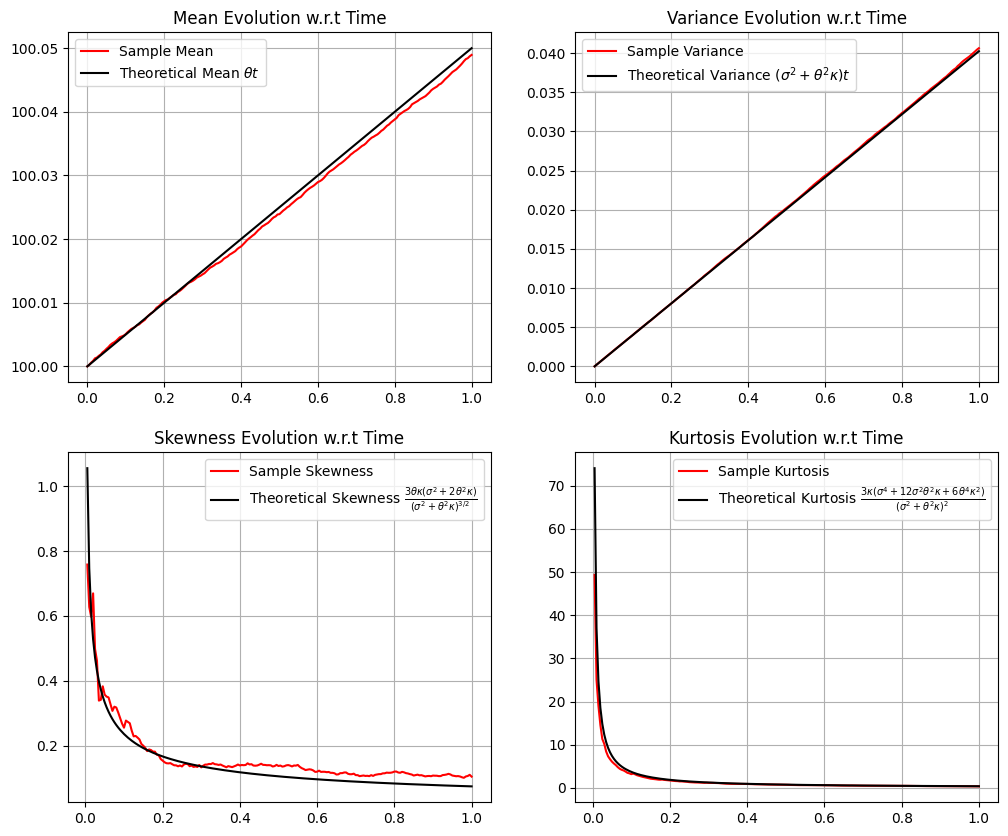

In [8]:
# Plotting Mean and Variance Convergence ============================================================
fig, ax = plt.subplots(2, 2, figsize = (12, 10), clear = True)

# Mean Convergence ----------------------------------------------------------------------------------
ax[0, 0].set_title("Mean Evolution w.r.t Time")
ax[0, 0].plot(t_steps, X.mean(axis = 1), color = "red", label = "Sample Mean")
ax[0, 0].plot(t_steps, exact_mean, color = "black", label = r"Theoretical Mean $\theta t$")
ax[0, 0].grid()
ax[0, 0].legend()

# Variance Convergence ------------------------------------------------------------------------------
ax[0, 1].set_title("Variance Evolution w.r.t Time")
ax[0, 1].plot(t_steps, X.var(axis = 1), color = "red", label = "Sample Variance")
ax[0, 1].plot(t_steps, exact_var, color = "black", label = r"Theoretical Variance $(\sigma^2+\theta^2\kappa)t$")
ax[0, 1].grid()
ax[0, 1].legend()

# Skewness Convergence ------------------------------------------------------------------------------
ax[1, 0].set_title("Skewness Evolution w.r.t Time")
ax[1, 0].plot(t_steps, stats.skew(X, axis = 1), color = "red", label = "Sample Skewness")
ax[1, 0].plot(t_steps, exact_skew, color = "black", label = r"Theoretical Skewness $\frac{3\theta\kappa(\sigma^2+2\theta^2\kappa)}{(\sigma^2+\theta^2\kappa)^{3/2}}$")
ax[1, 0].grid()
ax[1, 0].legend()

# Kurtosis Convergence ------------------------------------------------------------------------------
ax[1, 1].set_title("Kurtosis Evolution w.r.t Time")
ax[1, 1].plot(t_steps, stats.kurtosis(X, axis = 1), color = "red", label = "Sample Kurtosis")
ax[1, 1].plot(t_steps, exact_kurt, color = "black", label = r"Theoretical Kurtosis $\frac{3\kappa(\sigma^4+12\sigma^2\theta^2\kappa+6\theta^4\kappa^2)}{(\sigma^2+\theta^2\kappa)^2}$")
ax[1, 1].grid()
ax[1, 1].legend()

plt.show()